# Multiclass text classification using BERT
- toc: true
- badges: true
- categories: [Natural Language Processing, Hugging Face]
- permalink: /bert-multiclass-text-classification/
- description: a tutorial on mult-class text classfication using pretrained BERT model from HuggingFace

In this post, we'll do a simple text classification task using the pretained [BERT model]((https://huggingface.co/docs/transformers/model_doc/bert) from HuggingFace.

The BERT model was proposed in [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805), by Jacob Devlin, Ming-Wei Chang, Kenton Lee and Kristina Toutanova.


In [1]:
#hide
#!pip install transformers
import pandas as pd


In [2]:
#hide
import warnings
warnings.filterwarnings("ignore")

## Loading data



In [3]:

PRETRAINED_LM = "dbmdz/bert-base-french-europeana-cased"
%mkdir PRI_FR
TB_path="/content/PRI_FR"
BATCH_SIZE = 8


In [4]:
def build_data(in_file,POS):

    import csv

    max_length=0

    # Open the input file in read mode
    input_file = open(in_file+".conllu", "r")

    # Create an empty list to store the lines
    words = ""
    root= ""
    csv_line=[]



    with open(in_file+".csv", "w") as f:
        writer = csv.writer(f)
        writer.writerow(["text","label"])
        root_found=False
        # Loop through each line in the input file
        c=0
        for line in input_file:

          if line!="\n":
                words=words+(line.split()[1])+" "
                if line.split()[6]=="0" and not root_found:
                  root=POS[line.split()[3]]
                  root_found=True

          else:
                c+=1
                full_text=words[0:-1]
                root_found=False
                if len(words)>max_length: max_length= len(words.split(" "))
                csv_line.append(full_text)
                csv_line.append(str(root))
                writer.writerow(csv_line)


                csv_line=[]
                words = ""
                root= ""

    print('max_length',max_length,"\n","count of examples:",c)
    # Close the input file
    input_file.close()




In [5]:

POS={}
label_names=set()

for f in ["train","dev","test"]:
   temp_pos=set()
   input_file = open(f+".conllu", "r")
   for line in input_file:
    if line!="\n":
      if line.split()[6]=="0":
        label_names.add(line.split()[3])
        temp_pos.add(line.split()[3])
   print(f,len(temp_pos),"\n",temp_pos)

label_names=list(label_names)
for i in range(len(label_names)):
  POS[label_names[i]]=i



build_data("/content/train",POS)
build_data("/content/dev",POS)
build_data("/content/test",POS)


N_labels = len(label_names)
print(POS)
print(label_names)
print("N_labels: ",N_labels)

train_df=pd.read_csv("train.csv")
valid_df=pd.read_csv("dev.csv")
test_df=pd.read_csv("test.csv")

def count_pos(df,df_name):
    print("\n ---", df_name,"---\n")
    for i in range(N_labels):
        counter = len(df.loc[df['label'] == i])
        print(i,counter)

count_pos(train_df,"train")
count_pos(valid_df,"dev")
count_pos(test_df,"test")

train 8 
 {'NUM', 'PRON', 'NOUN', 'SYM', 'ADJ', 'VERB', 'ADV', 'PROPN'}
dev 5 
 {'PRON', 'NOUN', 'ADJ', 'VERB', 'PROPN'}
test 3 
 {'ADJ', 'NOUN', 'VERB'}
max_length 10 
 count of examples: 803
max_length 18 
 count of examples: 107
max_length 20 
 count of examples: 110
{'NUM': 0, 'PRON': 1, 'NOUN': 2, 'SYM': 3, 'ADJ': 4, 'VERB': 5, 'ADV': 6, 'PROPN': 7}
['NUM', 'PRON', 'NOUN', 'SYM', 'ADJ', 'VERB', 'ADV', 'PROPN']
N_labels:  8

 --- train ---

0 1
1 14
2 99
3 1
4 44
5 641
6 1
7 2

 --- dev ---

0 0
1 1
2 26
3 0
4 8
5 71
6 0
7 1

 --- test ---

0 0
1 0
2 5
3 0
4 7
5 98
6 0
7 0


In [ ]:
POS={0:'ADJ', 1:'NOUN', 2:'PROPN', 3:'VERB', 4:'NUM', 5:'PRON', 6:'ADV', 7:'SYM'}

In [ ]:
train_df.head()

## Tokenization

Tokenization is a process for spliting raw texts into tokens, and encoding the tokens into numeric data.

To do this, we first initialize a `BertTokenizer`:

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_LM, do_lower_case=True)
tokenizer

BertTokenizer(name_or_path='dbmdz/bert-base-french-europeana-cased', vocab_size=32000, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

define a function for encoding:

In [ ]:
def encode(docs):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=128, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

Use the `ecode` function to get input ids and attention masks of the datasets:

In [ ]:
train_input_ids, train_att_masks = encode(train_df['text'].values.tolist())
valid_input_ids, valid_att_masks = encode(valid_df['text'].values.tolist())
test_input_ids, test_att_masks = encode(test_df['text'].values.tolist())

<br>

## Creating `Dataset`s and `DataLoader`s

We'll use pytorch `Dataset` and `DataLoader` to split data into batches. For more detatils, you can check out another post on [DataLoader](https://www.intodeeplearning.com/how-to-load-datasets-from-hugging-face-datasets/).

Turn the labels into tensors:

In [ ]:
import torch
train_y = torch.LongTensor(train_df['label'].values.tolist())
valid_y = torch.LongTensor(valid_df['label'].values.tolist())
test_y = torch.LongTensor(test_df['label'].values.tolist())
train_y.size(),valid_y.size(),test_y.size()

(torch.Size([803]), torch.Size([107]), torch.Size([110]))

Create dataloaders for training

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

<br>

## Bert For Sequence Classification Model

We will initiate the  `BertForSequenceClassification ` model from Huggingface, which allows easily fine-tuning the pretrained BERT mode for classification task.


You will see a warning that some parts of the model are randomly initialized. This is normal since the classification head has not yet been trained.

In [ ]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(PRETRAINED_LM,
                                                      num_labels=N_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-french-europeana-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = model.cuda()

<br>

## Fine-tuning

### **Optimizer and Scheduler**

An **optimizer** is for tuning parameters in the model, which is set up with a learning rate.

Selection of the learning rate is important. In practice, it's common to use a **scheduler** to decrease the learning rate during training.

In [ ]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

EPOCHS = 30
LEARNING_RATE = 2e-6

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer,
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS )

<br>

### **Training Loop**

The training loop is where the magic of deep learning happens. The model will be fine-tuned on the emotion dataset for classification task.

In [ ]:
#collapse-output
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import numpy as np
import math

train_loss_per_epoch = []
val_loss_per_epoch = []


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()

            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))

    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train_df) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(valid_df) / BATCH_SIZE), valid_loss / (step_num_e + 1)))

Epoch:  1


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

101/101 train loss: 1.3808095815158126 
14/14 val loss: 1.1312888605254037 
Epoch:  2


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

101/101 train loss: 0.8073468317489813 
14/14 val loss: 0.9920798518827983 
Epoch:  3


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

101/101 train loss: 0.7300814491982507 
14/14 val loss: 0.9389229118824005 
Epoch:  4


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

101/101 train loss: 0.7047622525455928 
14/14 val loss: 0.902343579701015 
Epoch:  5


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

101/101 train loss: 0.6912858315033488 
14/14 val loss: 0.8771125195281846 
Epoch:  6


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

101/101 train loss: 0.6508399385331881 
14/14 val loss: 0.8325561338237354 
Epoch:  7


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

101/101 train loss: 0.6223284945924683 
14/14 val loss: 0.828204771237714 
Epoch:  8


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

101/101 train loss: 0.5883392416457138 
14/14 val loss: 0.7663652721260276 
Epoch:  9


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

101/101 train loss: 0.5492585240909369 
14/14 val loss: 0.7253101877868176 
Epoch:  10


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

101/101 train loss: 0.5102702981174583 
14/14 val loss: 0.7005586916846889 
Epoch:  11


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

101/101 train loss: 0.4645025585547532 
14/14 val loss: 0.6632881715361562 
Epoch:  12


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

101/101 train loss: 0.427849436492318 
14/14 val loss: 0.6464062492762294 
Epoch:  13


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

101/101 train loss: 0.38436015809674073 
14/14 val loss: 0.6722600529236453 
Epoch:  14


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

101/101 train loss: 0.35946865977332143 
14/14 val loss: 0.6579592698918921 
Epoch:  15


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

101/101 train loss: 0.3327238139982271 
14/14 val loss: 0.7236487872100302 
Epoch:  16


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

101/101 train loss: 0.3437674987397277 
14/14 val loss: 0.6744257593527436 
Epoch:  17


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

101/101 train loss: 0.30499166436493397 
14/14 val loss: 0.6688012146790113 
Epoch:  18


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

101/101 train loss: 0.2877407768870344 
14/14 val loss: 0.6858401919848153 
Epoch:  19


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

101/101 train loss: 0.29445167442802156 
14/14 val loss: 0.7178245748925421 
Epoch:  20


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

101/101 train loss: 0.2773144786790161 
14/14 val loss: 0.7143777455203235 
Epoch:  21


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

101/101 train loss: 0.26178463432237065 
14/14 val loss: 0.7207688308720078 
Epoch:  22


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

101/101 train loss: 0.2435358436870398 
14/14 val loss: 0.7291988246142864 
Epoch:  23


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

101/101 train loss: 0.24665349241493656 
14/14 val loss: 0.7179094266279468 
Epoch:  24


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

101/101 train loss: 0.23819937602165017 
14/14 val loss: 0.7438108662941626 
Epoch:  25


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

101/101 train loss: 0.22245734495728617 
14/14 val loss: 0.7211154288878399 
Epoch:  26


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

101/101 train loss: 0.21827203991573932 
14/14 val loss: 0.734669940546155 
Epoch:  27


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

101/101 train loss: 0.2212155039357667 
14/14 val loss: 0.7521834506520203 
Epoch:  28


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

101/101 train loss: 0.2146697112700284 
14/14 val loss: 0.7551836472536836 
Epoch:  29


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

101/101 train loss: 0.21942605258952272 
14/14 val loss: 0.7525700804378305 
Epoch:  30


Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

101/101 train loss: 0.21525490810486056 
14/14 val loss: 0.7539374509693256 


You can see in the output that the training and validation losses steadily decreases in each epoch.

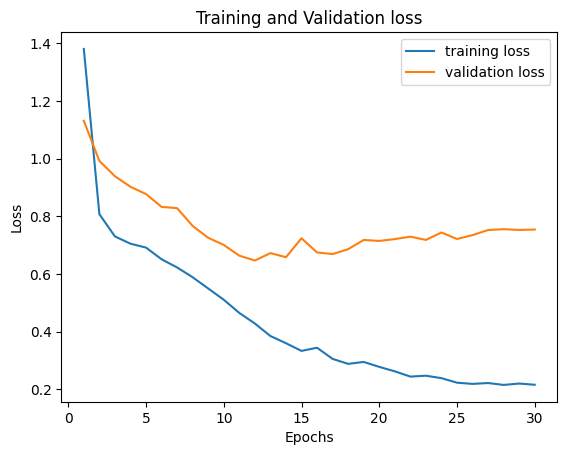

In [ ]:
from matplotlib import pyplot as plt
epochs = range(1, EPOCHS +1 )
fig, ax = plt.subplots()
ax.plot(epochs,train_loss_per_epoch,label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

## Performance Metrics
It's common to use precision, recall, and F1-score as the performance metrics.

In [ ]:
from sklearn.metrics import classification_report
#print('classifiation report')
#print(classification_report(valid_pred, valid_df['label'].to_numpy(), target_names=label_names))

## Error Analysis
With the predictions, we can plot the confusion matrix:

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels=None):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

In [ ]:
#plot_confusion_matrix(valid_pred,valid_df['label'].to_numpy(),labels=label_names)

You can see that **sadness** has a higher likelihood to be classified as **anger** or **fear**, leading to a lower f1 score.

<br>

## Prediction

*Now* let's use the trained model to predict the testing set.

In [ ]:
model.eval()
test_pred = []
test_loss= 0
with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        test_loss += loss.item()

        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)

0it [00:00, ?it/s]

In [ ]:
from sklearn.metrics import classification_report,accuracy_score
print('classifiation report\n')
print("pos count_in_pred")

for pos in set(test_pred):
  print(label_names[pos],list(test_pred).count(pos))
print("\n\npos count_in_test")
for pos in set(test_df['label'].to_numpy()):
  print(label_names[pos],list(test_df['label'].to_numpy()).count(pos))

print("\n\n Accuracy: ",round(accuracy_score(test_pred, test_df['label'].to_numpy())*100,2))
print(classification_report(test_pred, test_df['label'].to_numpy(),target_names=label_names))

classifiation report

pos count_in_pred
NOUN 3
VERB 107


pos count_in_test
ADJ 7
NOUN 5
VERB 98


 Accuracy:  88.18


ValueError: ignored

With the predictions, we can plot the confusion matrix again:

ValueError: ignored

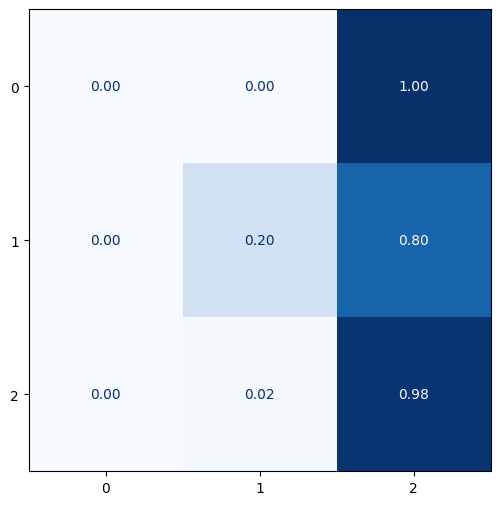

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
plot_confusion_matrix(test_pred,test_df['label'].to_numpy(),labels=label_names)

Output the misclassified text:

In [ ]:
test_df['pred'] = test_pred
test_df.reset_index(level=0)
print(test_df[test_df['label']!=test_df['pred']].shape)
test_df[test_df['label']!=test_df['pred']][['text','label','pred']].head(10)

(13, 3)


,text,label,pred
0,Paternité - Partage de les conditions initiale...,1,3
1,Toute utilisation de l' Oeuvre autrement qu' e...,0,3
3,Creative Commons n' est pas partie à ce contra...,1,3
7,"L' importance de la sécurité sur la route , su...",0,3
14,Mais le manque de lignes directrices est ici p...,0,3
34,"Si maman n' est pas contente , personne n' est...",0,3
45,Protocole relatif à les conditions et modalité...,1,3
67,Les mesures ainsi décidées sont immédiatement ...,0,3
82,Le mandat de l' un de les juges de la Cour de ...,3,1
85,Le mandat de l' un de les juges de le tribunal...,3,1


In [ ]:
#hide

test_df.to_csv(TB_path+"/test_results.csv",index= False)
valid_df.to_csv(TB_path+"/dev_results.csv",index= False)

In [ ]:


from google.colab import files
%cd /content/





!zip -r PRI_FR.zip PRI_FR
files.download('PRI_FR.zip')


/content
  adding: PRI_FR/ (stored 0%)
  adding: PRI_FR/dev_results.csv (deflated 57%)
  adding: PRI_FR/test_results.csv (deflated 65%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>